In [1]:
#Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import requests
import pickle

## Assignment 1.1 - Exploring WS And BA Models

#### What's the problem with random networks as a model for real-world networks according to the argument in section 3.5 (near the end)?

The problem using random networks, to model real-world networks stems from the lack of outliers within the generated dataset. The book mentions people like President Rosevelt that had 22.000 acquaintances or Facebook users with the max amount of 5000 friends.

All data points wihtin the random network lie in the ranger of ⟨k⟩ &plusmn; $\sigma_k$ which as per the reasoning above would miss crucial data points that reflect the real world.

#### List the four regimes that characterize random networks as a function of ⟨k⟩.

The four regimes are: 

* Subcritical - 0 < ⟨k⟩ < 1 
* Critical  - ⟨k⟩ = 1
* Supercritical - ⟨k⟩ > 1
* Connected - ⟨k⟩ = ln(N)


#### According to the book, why is it a problem for random networks (in terms of being a model for real-world networks) that the degree-dependent clustering C(k) decreases as a function of k in real-world networks?

This is because the random network predictions, predict that the clustering coefficient is non-dependent on the amount of degrees a node has but rather the average degree across the whole network. That means that the random network does not take grouping into account where the coefficient is much higher.


### Use nx.watts_strogatz_graph to generate 3 graphs with 500 nodes each, average degree = 4, and rewiring probablity  p=0, 0.1, and  1.

In [2]:
# Generation of WS graphs.

AVG_DEG = 4
N = 500

p0 = nx.watts_strogatz_graph(N, AVG_DEG, 0)
p01 = nx.watts_strogatz_graph(N, AVG_DEG, 0.1)
p1 = nx.watts_strogatz_graph(N, AVG_DEG, 1)

#### Calculate the average shortest path length ⟨d⟩ for each one.

As WS graphs start as ring lattices, connected to k-nearest neighbors, and "shortcuts" has p chance to replace existing edges. We can derive the following:

As p0 has p = 0, this means there are no "shortcuts", meaning the furthest away node is the the node completely opposite of the starting node. Also, as ⟨k⟩ is even the longest step is ⟨k⟩/2 nodes. The average distance to any node in a ring lattice, is (N/2 + 1)/2. Thus we can derive ⟨d⟩ = ((N/2 + 1)/2)/(⟨k⟩/2).

As nx.watts_strogatz_graph returns a small world graph for intermediate p-values meaning 0 < p <= 1, we can find the formula average shortest path from the book in Section 3.8 formula 3.19. 

This formula is presented as: ⟨d⟩ = ln(N)/ln(⟨k⟩)

As the only difference between the last 2 graphs are the rewiring probability, p. We can calculate the approx. shortest path as a random graph.

In [3]:
d0 = ((N/2 + 1)/2)/(AVG_DEG/2)
print(f'The average shortest path for p=0: {d0}')

d = np.log(N)/np.log(AVG_DEG)
print(f'The average shortest path for p=1 and p=0.1: {round(d,2)}')

The average shortest path for p=0: 62.75
The average shortest path for p=1 and p=0.1: 4.48


#### Describe what happens to the network when p=1

When a WS graph has a rewiring possiblity of 1, all edges are replaces with "shortcuts" making in that way much like the ER graph. Yet, in the WS graph, each node still has exactly ⟨k⟩ edges, while the ER graph degree distribution is centered around ⟨k⟩.

#### What's the value of p for which the average shortest path length gets close to the short paths we find in a fully randomized network.

In [4]:
# Generation of 200 of WS graphs with different p values and calculating their average shortest path length
# Generating a single ER graph for baseline comparison
seed = 1

#Generate an array of values with different p values
p_values = np.linspace(1*10**-5, 1, 200)
avg_shortest_paths = []
for p in p_values:
    G = nx.watts_strogatz_graph(N, AVG_DEG, p, seed=seed)
    avg_shortest_path = nx.average_shortest_path_length(G)
    avg_shortest_paths.append({p: avg_shortest_path})


# one ER baseline
prob = AVG_DEG / (N - 1)
G_er = nx.erdos_renyi_graph(N, prob, seed=seed)
if not nx.is_connected(G_er):
    GCC = max(nx.connected_components(G_er), key=len)
    G_er = G_er.subgraph(GCC).copy()
L_er = nx.average_shortest_path_length(G_er)


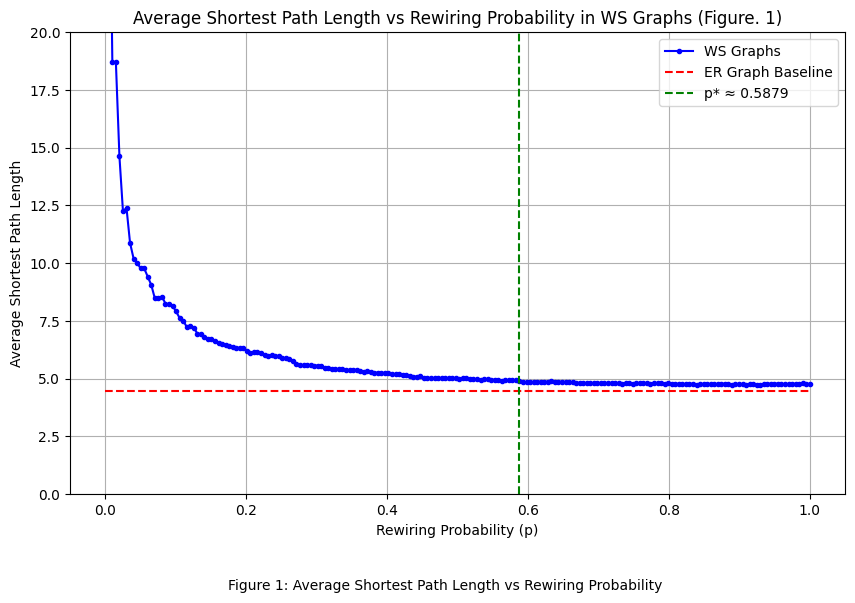

In [5]:
#Plot the results
delta = 0.1  # 10% tolerance; change as you like
L_ws = [list(d.values())[0] for d in avg_shortest_paths]

# 1) Find first p where WS is within (1+delta) of the baseline
target = (1 + delta) * L_er
idx = np.where(np.array(L_ws) <= target)[0]
p_star = p_values[idx[0]] if len(idx) else None

plt.figure(1, figsize=(10, 6))
plt.plot(p_values, L_ws, marker='o', markersize=3, color='blue', label='WS Graphs')
plt.hlines(L_er, color='red', xmin=0, xmax=max(p_values), linestyle='--', label='ER Graph Baseline')
plt.vlines(p_star, color='green', ymin=0, ymax=20, linestyle='--', label=f'p* ≈ {p_star:.4f}' if p_star else 'No p* found')
plt.ylim(0, 20)
plt.xlabel('Rewiring Probability (p)')
plt.ylabel('Average Shortest Path Length')
plt.title('Average Shortest Path Length vs Rewiring Probability in WS Graphs (Figure. 1)')
plt.grid(True)
plt.figtext(0.5, -0.05, "Figure 1: Average Shortest Path Length vs Rewiring Probability", wrap=True,
horizontalalignment='center', fontsize=10)

plt.legend()
plt.show()

The value at which p is accepted has been chosen to be within 10% of the fully random networks average shortest path.

We have generated WS graphs for 200 different p values. As seen in figure 1, as p approaches 1 the corresponding average shortest path converges on the ER baseline. 

As mentioned accepted vakues has to be within 10% of the baseline, this happens when p reaches 0.5879 for this particular seed.

#### Generate 50 networks with  N=500,  ⟨k⟩=4, for each of  p={0,0.01,0.03,0.05,0.1,0.2}. Calculate the average of  ⟨d⟩ as well as the standard deviation over the 50 networks, to create a plot that shows how the path length decreases very quickly with only a little fraction of re-wiring. Use the standard deviation to add errorbars to the plot.

In [6]:
p_values = [0, 0.01, 0.03, 0.05, 0.1, 0.2]
repeats = 50
avg_paths = []

means = []
stds = []

for p in p_values:
    curr_paths = []
    for r in range(repeats):
        G = nx.watts_strogatz_graph(N, AVG_DEG, p)
        avg_path = nx.average_shortest_path_length(G)
        curr_paths.append({p: avg_path})
    avg_paths.append(curr_paths)
    means.append(np.array([list(d.values())[0] for d in curr_paths]).mean())
    stds.append(np.array([list(d.values())[0] for d in curr_paths]).std())


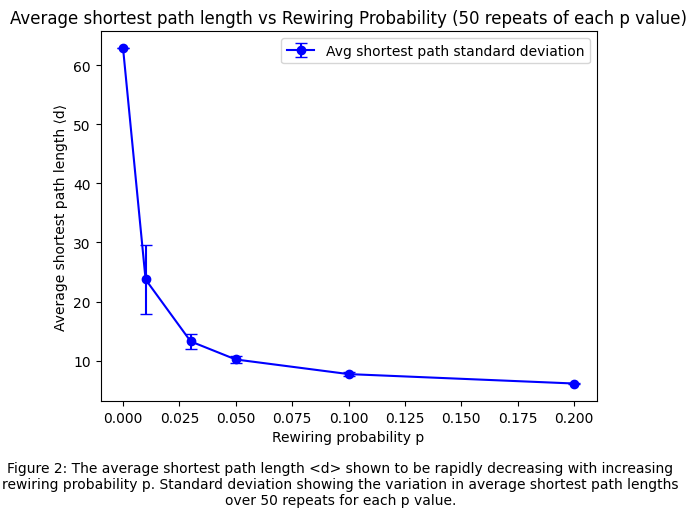

In [7]:
#Plot the results

import textwrap

plt.errorbar(p_values, means, yerr=stds, fmt='o-', capsize=4, label="Avg shortest path standard deviation", color='blue')
plt.xlabel("Rewiring probability p")
plt.ylabel("Average shortest path length ⟨d⟩")
plt.title("Average shortest path length vs Rewiring Probability (50 repeats of each p value)")
caption = (
    "Figure 2: The average shortest path length <d> shown to be rapidly decreasing with increasing rewiring probability p. "
    "Standard deviation showing the variation in average shortest path lengths over 50 repeats for each p value."
)
wrapped = textwrap.fill(caption, width=100)
plt.figtext(0.5, -0.10, wrapped, wrap=True,
            ha='center', fontsize=10)
plt.legend()
plt.show()

#### BA model step by step

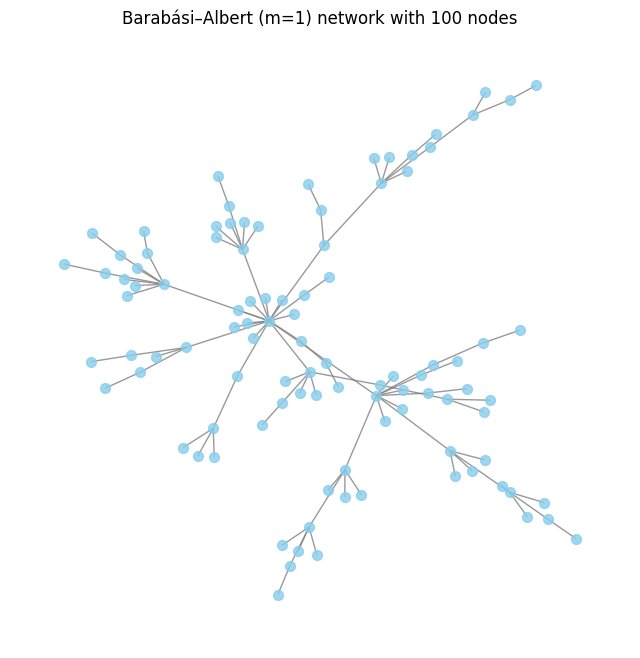

Max degree: 78
Min degree: 1


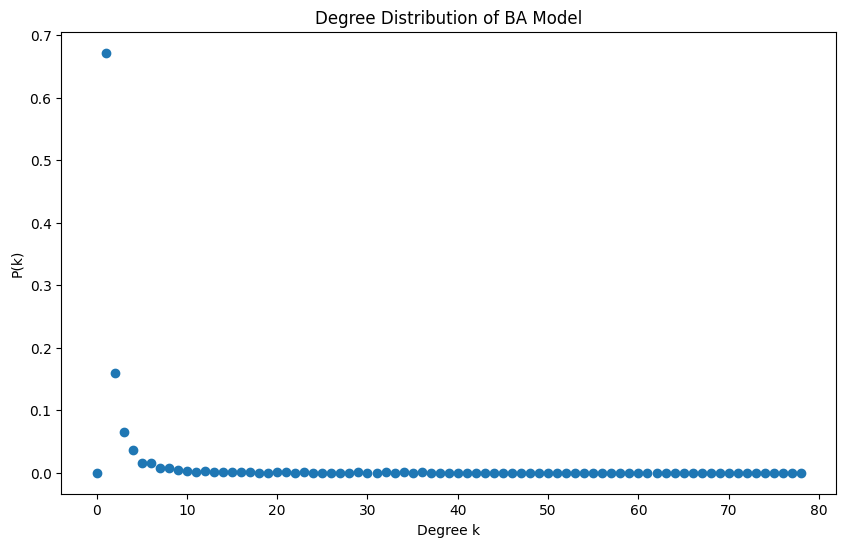

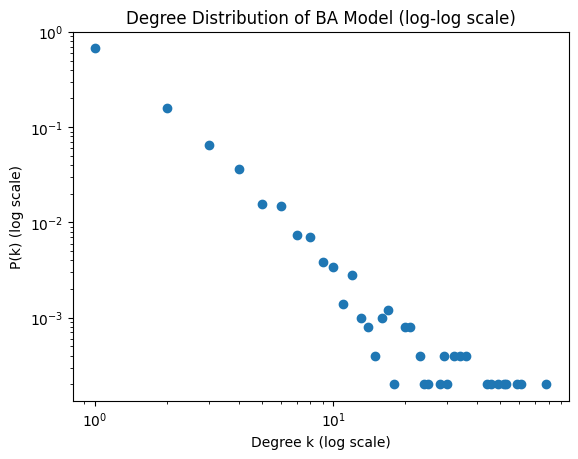

In [8]:
# BA model creation

#First create a graph consisting of a single link.
G = nx.Graph()
G.add_nodes_from([0, 1])
G.add_edge(0, 1)

#Adding another node, and connecting it to one of the existing nodes. They both have degree 1 so equal probability.
G.add_node(2)
G.add_edge(2, 0)  #We choose to connect to node 0.

# Use the number_of_nodes method to get the current number of nodes in G.
while G.number_of_nodes() < 100:
    new_node = G.number_of_nodes()
    G.add_node(new_node)
    
    # Calculate the degree of each existing node
    degrees = np.array([G.degree(n) for n in G.nodes()])
    total_degree = degrees.sum()
    
    # Calculate the probability of connecting to each existing node
    probabilities = degrees / total_degree
    
    # Choose an existing node to connect to based on the calculated probabilities
    existing_node = np.random.choice(G.nodes(), p=probabilities)
    
    # Add an edge between the new node and the chosen existing node
    G.add_edge(new_node, existing_node)

pos = nx.spring_layout(G, seed=42)  #Nicer layout
plt.figure(figsize=(8, 8))          #Bigger canvas

#Styling the nodes and edges
nx.draw_networkx(
    G, pos,
    with_labels=False,
    node_color='skyblue',
    edge_color='gray',
    node_size=50,
    alpha=0.8                       
)

#Adding title and removing axes
plt.title("Barabási–Albert (m=1) network with 100 nodes")
plt.axis("off")
plt.show()

# Add 5000 nodes. Same as above, but now with 5000 nodes.
while G.number_of_nodes() < 5000:
    new_node = G.number_of_nodes()
    G.add_node(new_node)
    
    degrees = np.array([G.degree(n) for n in G.nodes()])
    total_degree = degrees.sum()
    
    probabilities = degrees / total_degree
    
    existing_node = np.random.choice(G.nodes(), p=probabilities)
    
    G.add_edge(new_node, existing_node)

print(f"Max degree: {max(dict(G.degree()).values())}")
print(f"Min degree: {min(dict(G.degree()).values())}")

#Bin the degrees for histogram
degrees = [G.degree(n) for n in G.nodes()]

#Get max range
max_degree = max(degrees)

#Creating bins
bins = np.arange(0, max_degree + 2) - 0.5

#Creating histogram, using the bins.
hist, bin_edges = np.histogram(degrees, bins=bins, density=True)

#Find bin centers.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

#Plot styling for linear and log-log plots
plt.figure(figsize=(10, 6))
plt.xlabel('Degree k')
plt.ylabel('P(k)')
plt.title('Degree Distribution of BA Model')
plt.plot(bin_centers, hist, marker="o", linestyle='None')
plt.show()

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree k (log scale)')
plt.ylabel('P(k) (log scale)')
plt.title('Degree Distribution of BA Model (log-log scale)')
plt.plot(bin_centers, hist, marker="o", linestyle='None')
plt.show()


## Assignment 1.2


#### Explain your process

The first step was cleaning the list of Rock Musicians. Even though we had read up a bit on regex we decided to use a LLM to create the neccessary expression, '\[\[([^\[\]|]+?)(?:\|[^\[\]]+)?\]\]', which was tested on https://regex101.com/. The regex only extracted the page name. We manually loaded the wikitext in a .txt file. and then used the "re" library to find the text matching the regex. After that all matches were iterated over in a for loop removing the redundant name if the artist link contained both a display name and the link keeping the link. We also checked for duplicates in case any artist got copied twice. A manual check of the list revealed that the music label "AllMusic had been retrieved aswell, and was then deleted.


Hereafter we needed to download the wikitext for each artist. The first step is retrieving the list of artists, the a directory is created to put all the .txt files in. Iterating over the list of artists, each artist name is reformatted to match the expected URL format, and then an API request is sent to wikipedia for each artists. A list kept track of which requests failed, resulting in a list of 5 artists, this was saved in a meta data Json. This was due to special characters in their name which didn't fit the url format. The easiest fix was to simply make a list of the 5 artists with the correct formatting and then downloading the remaining texts.

Now we could traverse the network and build the files. Here the approach was to iterate over each file in the wiki text directory and then add a node, and outgoing edges corresponding to links matching our list of artists. Before this happens though, the wiki text is counted. Using regex HTML tags, links, headers and table markup is removed. Then the cleaned text is saved in a new variable to preserve the original. Then the length of the file is found and that is used as basis for the word count. The first issue became apparent when way too many nodes were being added. This was due to nodes being duplicated by first being added as the endpoint for an outgoing edge, and then being added again when iteration came their own wiki file. The solution was to introduce a check, before adding a node, that it was not already added.

Using the same Regular Expression, as when creating the artist link, all links are identified and saved in a list. Then the link list is iterated checking whether the link is the same as the name of the artists whose wiki text is currently being checked, in which case the link is discarded. If the link is not the same artist, then we check whether it exists in the list of artists in our network. If that is the case the edge is added to the network. If the link is not already added to the network, it is first added as a node with a word count of 0. The word count is then updated when the iteration comes to the respective wiki file. 

After the script had run we checked the number of nodes and edges, and compared it with other groups. Here we could conclude similar results. We also checked the names of the first and last 10 nodes to check whether the matched bands in our list. 

#### Challenges
Even though we both have experience making API request we had some minor issues getting the headers and params correct. Here the wikipedia API documentation was helpful. We also encountered the issue of invalid characters for request url. A more graceful solution could have probably been found, but just manually editing the urls was decided to be the easiest. It was probably the most frustrating part having waited for the wikitexts to download only realise all the requests had failed. The biggest challenge however was dealing with the regex, and using it to remove all the unneccessary parts. In the initial setup of the network traversal, items were included as nodes since the regex didn't match properly. 

#### Use of LLM and what could have been done differently
Using the LLM for the regex, was a bit of a challenge and much testing was needed to check the work. Furthermore, LLM's were used to help with the debugging. At times it was also used to explain the way certain functions worked, like adding an attribute to a node in the network. 

If we started over we would have probably compartmentalised the code a bit more creating functions for different purposes, making the code easier to debug and maintain an overview. 




Number of nodes: 484
Number of edges: 7197


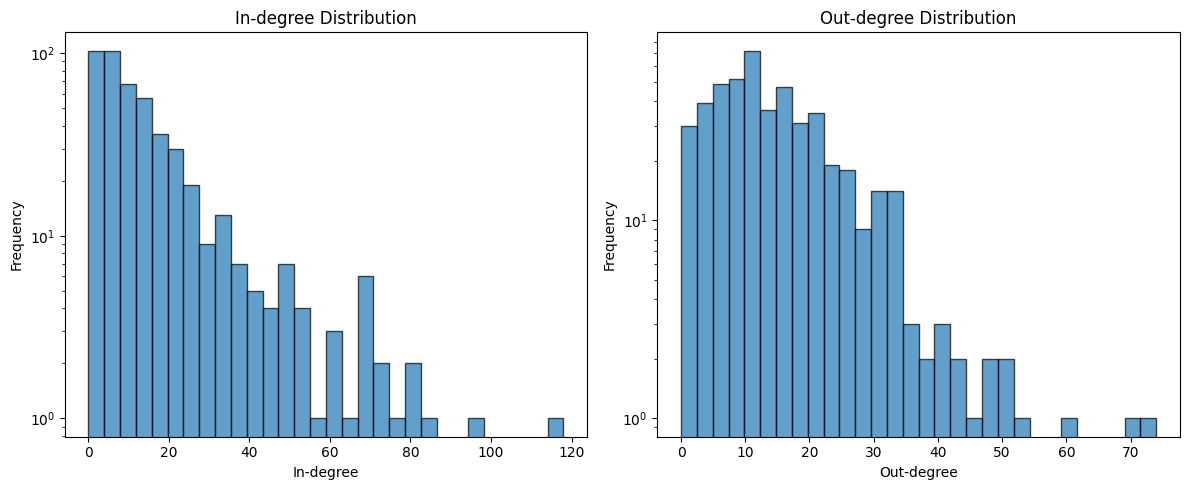

   Max in-degree: 118
   Max out-degree: 74


In [ ]:
# Retrieving the rock network without 0 degree nodes from GitHub

url = 'https://raw.githubusercontent.com/LucasJuel/socialgraphs2025/main/assignments/Assignment%201/rock_artists_network.pkl'
response = requests.get(url)

G_rock = pickle.loads(response.content)

# Simple network statistics and analysis 
# Print number of nodes and edges
nodes = G_rock.number_of_nodes()
edges = G_rock.number_of_edges()
print(f'Number of nodes: {nodes}')
print(f'Number of edges: {edges}')

# Then we calculate in and out degree distributions
in_degrees = [d for n, d in G_rock.in_degree()]
out_degrees = [d for n, d in G_rock.out_degree()]

# Plot in-degree and out-degree distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(in_degrees, bins=30, edgecolor='black', alpha=0.7)
ax1.set_xlabel('In-degree')
ax1.set_ylabel('Frequency')
ax1.set_title('In-degree Distribution')
ax1.set_yscale('log')  # Log scale often reveals power law

ax2.hist(out_degrees, bins=30, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Out-degree')
ax2.set_ylabel('Frequency')
ax2.set_title('Out-degree Distribution')
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('degree_distributions.png')
plt.show()

print(f"Max in-degree: {max(in_degrees)}")
print(f"Max out-degree: {max(out_degrees)}")


#### Simple network statistics and analysis

How many nodes and links are there in the network?

There are 484 nodes and 7197 edges(links) in the network.

Observations of the in and out degree distributions:
It can be observed that the two distributions differ. Notably the in degrees max is a lot higher. This can be explained by older and very influential artists, would be referenced by newer artists which were influenced by them. This could also explain the high number of artists with few in degrees, meaning newer artists which is not referenced but only reference their influences. 



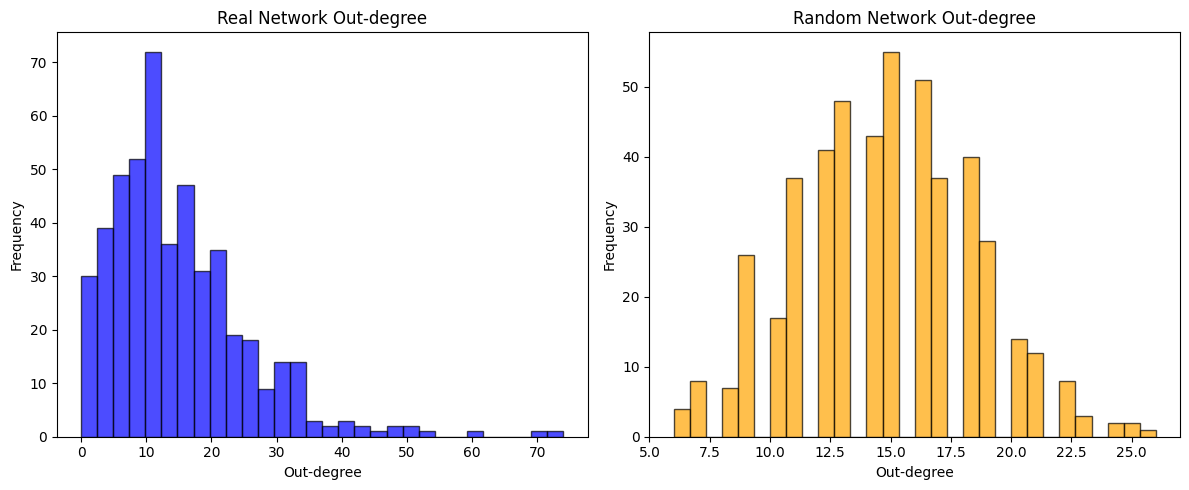

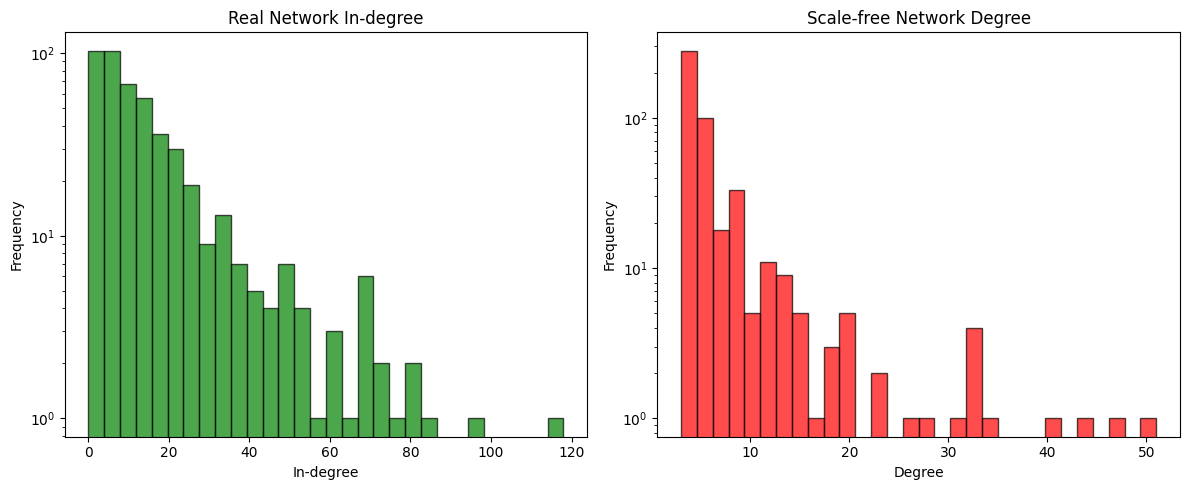

In [10]:
# Compare out-degree to random network

random_graph = nx.erdos_renyi_graph(nodes, edges/(nodes*(nodes-1)), directed=True)
random_out_degrees = [d for n, d in random_graph.out_degree()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(out_degrees, bins=30, edgecolor='black', alpha=0.7, color='blue')
ax1.set_xlabel('Out-degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Real Network Out-degree')

ax2.hist(random_out_degrees, bins=30, edgecolor='black', alpha=0.7, color='orange')
ax2.set_xlabel('Out-degree')
ax2.set_ylabel('Frequency')
ax2.set_title('Random Network Out-degree')

plt.tight_layout()
plt.savefig('random_comparison.png')
plt.show()

# Comparing in degree to scale-free network

scale_free = nx.barabasi_albert_graph(nodes, 3)
scale_free_degrees = [d for n, d in scale_free.degree()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(in_degrees, bins=30, edgecolor='black', alpha=0.7, color='green')
ax1.set_xlabel('In-degree')
ax1.set_ylabel('Frequency')
ax1.set_title('Real Network In-degree')
ax1.set_yscale('log')

ax2.hist(scale_free_degrees, bins=30, edgecolor='black', alpha=0.7, color='red')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Frequency')
ax2.set_title('Scale-free Network Degree')
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('scale_free_comparison.png')
plt.show()
    

Comparing the out degree to a ER graph:

The rock artist network skews very much to the left with a long tail, whereas the ER network is normal distributed. This indicates that the ER network does not account for the fact that most artists have few a outgoing degrees and with some few outliers having a lot.


Comparing the in degree to a scale-free network:
Here the distribution here looks more similar. But the scale-free network has a shorter tail with a significantly lower max in-degree. 


In [11]:
# Top 5 most connected performers

in_degree_dict = dict(G_rock.in_degree())
out_degree_dict = dict(G_rock.out_degree())

top_in = sorted(in_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]
top_out = sorted(out_degree_dict.items(), key=lambda x: x[1], reverse=True)[:5]

print("\n   Top 5 by in-degree (most referenced by others):")
for artist, degree in top_in:
    print(f"   {artist}: {degree}")

print("\n   Top 5 by out-degree (references most others):")
for artist, degree in top_out:
    print(f"   {artist}: {degree}")



   Top 5 by in-degree (most referenced by others):
   Led Zeppelin: 118
   Bob Dylan: 95
   Queen (band): 86
   David Bowie: 82
   Metallica: 81

   Top 5 by out-degree (references most others):
   Alice in Chains: 74
   Deep Purple: 71
   Black Sabbath: 60
   Def Leppard: 52
   Bryan Adams: 51


Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)?

It is not suprising that the top 5 in degree nodes are older and influential bands with a wide reach.

The top 5 bands with the highest out degrees. Is also older bands. It makes sense for older bands to reference other musicians more often, since they have more intertwined histoy.

In [12]:
# Top 10 longest wiki entries
print("\n Top 10 pages with longest wiki entries:")

word_counts = {node: G_rock.nodes[node].get('word_count', 0) for node in G_rock.nodes()}
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

for artist, words in top_words:
    print(f"   {artist}: {words} words")



 Top 10 pages with longest wiki entries:
   Bob Dylan: 18086 words
   The Beach Boys: 17736 words
   Frank Zappa: 16423 words
   Elvis Presley: 16388 words
   Paul McCartney: 16180 words
   The Beatles: 15881 words
   Queen (band): 15695 words
   The Rolling Stones: 15246 words
   U2: 14844 words
   David Bowie: 14354 words


What are the 10 pages with the longest wiki entries? 

Here it can be seen again that the musicians with the longest entries are some of the older artists, with more history and influence. It is a bit suprising that Paul McCartneys entry is longer that The Beatles.
